**Función para pintar las gráficas**

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Obtener las métricas del historial
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Crear un gráfico de pérdida
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Crear un gráfico de precisión
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


<p>Combinamos nuestro modelo generado con MobilenetV2</p>

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Concatenate, Input, GlobalAveragePooling2D, Dense

# Definimos las entradas
input_shape = (128, 128, 3)  # Tamaño de entrada para tu modelo
input_tensor_mobilenet = Input(shape=input_shape)
input_tensor_custom = Input(shape=input_shape)

# Cargamos nuestro modelo personalizado
tu_modelo = load_model("/content/modelo_entrenado2.h5")  # Carga tu modelo

# Cargamos MobileNetV2
mobilenet_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Congelamos las capas de MobileNetV2
for layer in mobilenet_model.layers:
    layer.trainable = False

# Modificamos la salida de MobileNetV2 para clasificar en 4 categorías
x_mobilenet = GlobalAveragePooling2D()(mobilenet_model(input_tensor_mobilenet))
x_mobilenet = Dense(4, activation='softmax')(x_mobilenet)

# Obtenemos la salida de nuestro modelo personalizado
x_tu_modelo = tu_modelo(input_tensor_custom)

# Concatenamos las salidas de ambos modelos
combined_output = Concatenate()([x_mobilenet, x_tu_modelo])  # Suponiendo que queremos concatenar las salidas

# Creamos un nuevo modelo combinando las salidas
combined_model = Model(inputs=[input_tensor_mobilenet, input_tensor_custom], outputs=combined_output)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Montamos Google Drive en Google Colab
from google.colab import drive
drive.mount('/content/drive')

# Cargamos los datos desde los archivo CSV en Google Drive
train_df = pd.read_csv('/content/drive/MyDrive/resultadosXytrain.csv', delimiter=';', nrows=700)
test_df = pd.read_csv('/content/drive/MyDrive/resultadosXytest.csv', delimiter=';', nrows=700)

# Aplicamos la función eval a la columna 'Image' para convertir las listas en arrays numpy
train_df['Image'] = train_df['Image'].apply(eval)
test_df['Image'] = test_df['Image'].apply(eval)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Convertimos la columna 'Label' a números usando LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(train_df['Label'])

train_df['Label'] = label_encoder.transform(train_df['Label'])
test_df['Label'] = label_encoder.transform(test_df['Label'])


# Convertim los datos a arrays numpy
X_train = np.array(train_df['Image'].tolist())
X_test = np.array(test_df['Image'].tolist())

y_train = train_df['Label']
y_test = test_df['Label']

In [ ]:
# Descongelamos algunas capas de MobileNetV2
for layer in combined_model.layers[-10:]:
    layer.trainable = True

# Compilamos el modelo nuevamente
combined_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenamos el modelo con ajuste fino
history = combined_model.fit([X_train, X_train], y_train, epochs=100, batch_size=32, validation_data=([X_test, X_test], y_test))

# Evaluamos el modelo en el conjunto de prueba
test_loss, test_acc = combined_model.evaluate([X_test, X_test], y_test)
print(f'\nPrecisión en el conjunto de prueba: {test_acc}')
print(f'\nPérdida en el conjunto de prueba: {test_loss}')

Epoch 1/100
22/22 [==============================] - 38s 323ms/step - loss: 1.7878 - accuracy: 0.4629 - val_loss: 3.1215 - val_accuracy: 0.6086
Epoch 2/100
22/22 [==============================] - 2s 100ms/step - loss: 1.3635 - accuracy: 0.5400 - val_loss: 2.5152 - val_accuracy: 0.6086
Epoch 3/100
22/22 [==============================] - 2s 102ms/step - loss: 1.1718 - accuracy: 0.6614 - val_loss: 1.4589 - val_accuracy: 0.5214
Epoch 4/100
22/22 [==============================] - 2s 100ms/step - loss: 1.0680 - accuracy: 0.7586 - val_loss: 1.8912 - val_accuracy: 0.3857
Epoch 5/100
22/22 [==============================] - 2s 102ms/step - loss: 0.9279 - accuracy: 0.8500 - val_loss: 1.9870 - val_accuracy: 0.6014
Epoch 6/100
22/22 [==============================] - 2s 105ms/step - loss: 0.9628 - accuracy: 0.8414 - val_loss: 1.6582 - val_accuracy: 0.6029
Epoch 7/100
22/22 [==============================] - 2s 92ms/step - loss: 1.0945 - accuracy: 0.7614 - val_loss: 1.9710 - val_accuracy: 0.6086

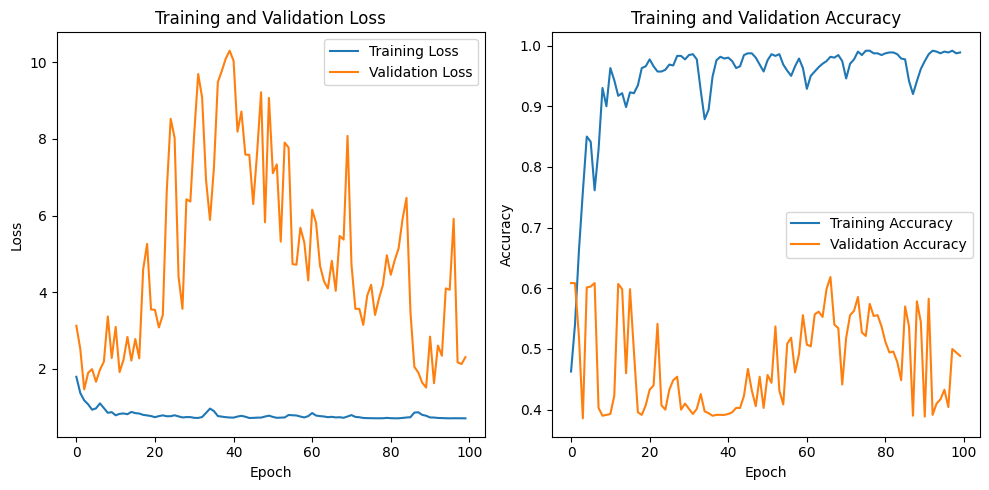

In [ ]:
plot_training_history(history)

**MobilenetV2**

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import numpy as np


# Cargar MobileNetV2 preentrenado en ImageNet sin la capa densa superior
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Congelar todas las capas convolucionales de MobileNetV2
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas adicionales para adaptar MobileNetV2 a tu conjunto de datos
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Reducir la tasa de aprendizaje cuando la métrica de validación se estanque
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr]
)

# Evaluar el modelo en el conjunto de test
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {test_acc}')
print(f'Pérdida en el conjunto de prueba: {test_loss}')



9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/100
22/22 [==============================] - 11s 142ms/step - loss: 0.8667 - accuracy: 0.5314 - val_loss: 0.6711 - val_accuracy: 0.5900 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 1s 33ms/step - loss: 0.6624 - accuracy: 0.6271 - val_loss: 0.7157 - val_accuracy: 0.5086 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 1s 32ms/step - loss: 0.6309 - accuracy: 0.6314 - val_loss: 0.6589 - val_accuracy: 0.6243 - lr: 0.0010
Epoch 4/100
22/22 [==============================] - 1s 32ms/step - loss: 0.5880 - accuracy: 0.6914 - val_loss: 0.6754 - val_accuracy: 0.5943 - lr: 0.0010
Epoch 5/100
22/22 [==============================] - 1s 32ms/step - loss: 0.5824 - accuracy: 0.6786 - val_loss: 0.6887 - val_accuracy: 0.6286 - lr: 0.0010
Epoch 6/100
22/22 [==============================] - 1s 47ms/step - loss: 0.5310 - accuracy: 0.7243 - val_loss: 0.6788 - val_accuracy: 0.6271 - lr: 0.0010
Epoch

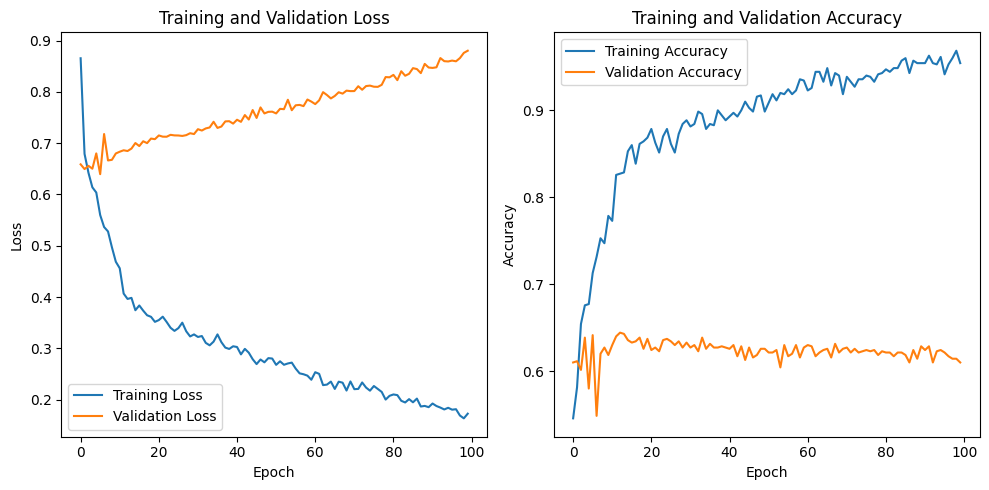

In [ ]:
plot_training_history(history)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2422081 (9.24 MB)
Trainable params: 164097

**MobilenetV3**

In [ ]:
from keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Convertir las etiquetas de entrenamiento a codificación en caliente
y_train_encoded = to_categorical(y_train, num_classes=2)

# Convertir las etiquetas de prueba a codificación en caliente
y_test_encoded = to_categorical(y_test, num_classes=2)

# Cargar MobileNetV3 preentrenado en ImageNet sin la capa densa superior
base_model = MobileNetV3Small(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Congelar todas las capas convolucionales de MobileNetV3
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas adicionales para adaptar MobileNetV3 a tu conjunto de datos
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 neuronas para 2 salidas con activación softmax
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Reducir la tasa de aprendizaje cuando la métrica de validación se estanque
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Configurar detención temprana (Early Stopping)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    X_train, y_train_encoded,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test_encoded),
    callbacks=[reduce_lr, early_stopping]
)

# Evaluar el modelo en el conjunto de test
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f'Precisión en el conjunto de prueba: {test_acc}')
print(f'Pérdida en el conjunto de prueba: {test_loss}')


4334752/4334752 [==============================] - 0s 0us/step
Epoch 1/100
22/22 [==============================] - 8s 137ms/step - loss: 4.7640 - accuracy: 0.5286 - val_loss: 3.5940 - val_accuracy: 0.6086 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 1s 31ms/step - loss: 2.9261 - accuracy: 0.5200 - val_loss: 2.3080 - val_accuracy: 0.3914 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 1s 29ms/step - loss: 1.9718 - accuracy: 0.5071 - val_loss: 1.6380 - val_accuracy: 0.6086 - lr: 0.0010
Epoch 4/100
22/22 [==============================] - 1s 52ms/step - loss: 1.4744 - accuracy: 0.5243 - val_loss: 1.3099 - val_accuracy: 0.3914 - lr: 0.0010
Epoch 5/100
22/22 [==============================] - 1s 51ms/step - loss: 1.2192 - accuracy: 0.5214 - val_loss: 1.1215 - val_accuracy: 0.6086 - lr: 0.0010
Epoch 6/100
22/22 [==============================] - 1s 33ms/step - loss: 1.0734 - accuracy: 0.5171 - val_loss: 1.0137 - val_accuracy: 0.6086 - lr: 0.0010
Epoch 

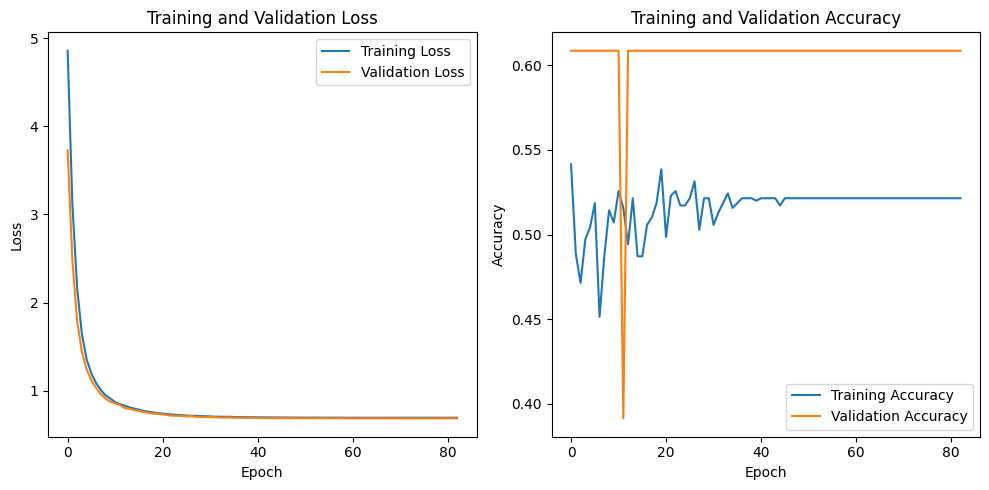

In [ ]:
plot_training_history(history)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 4, 4, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d_1  (None, 576)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               147712    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)              

**ResNet**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Creamos el modelo de ResNet50 preentrenado
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congelamos las capas convolucionales de ResNet50
for layer in base_model.layers:
    layer.trainable = False

# Añadimos capas adicionales al modelo
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Solo necesitas una neurona para la clasificación binaria
])

# Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Reducimos la tasa de aprendizaje cuando la métrica de validación se estanca
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Configuramos la detención temprana (Early Stopping)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamos el modelo
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, early_stopping]
)

# Evaluamos el modelo en el conjunto de test
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {test_acc}')
print(f'Pérdida en el conjunto de prueba: {test_loss}')


94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/100
22/22 [==============================] - 10s 230ms/step - loss: 0.7526 - accuracy: 0.5200 - val_loss: 0.7095 - val_accuracy: 0.3914 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 2s 106ms/step - loss: 0.7200 - accuracy: 0.5114 - val_loss: 0.6929 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 1s 69ms/step - loss: 0.7140 - accuracy: 0.5043 - val_loss: 0.7028 - val_accuracy: 0.3914 - lr: 0.0010
Epoch 4/100
22/22 [==============================] - 2s 75ms/step - loss: 0.7078 - accuracy: 0.4857 - val_loss: 0.6852 - val_accuracy: 0.6086 - lr: 0.0010
Epoch 5/100
22/22 [==============================] - 2s 96ms/step - loss: 0.7087 - accuracy: 0.4771 - val_loss: 0.7007 - val_accuracy: 0.3914 - lr: 0.0010
Epoch 6/100
22/22 [==============================] - 2s 75ms/step - loss: 0.7010 - accuracy: 0.4929 - val_loss: 0.6833 - val_accuracy: 0.6086 - lr: 0.0010
Ep

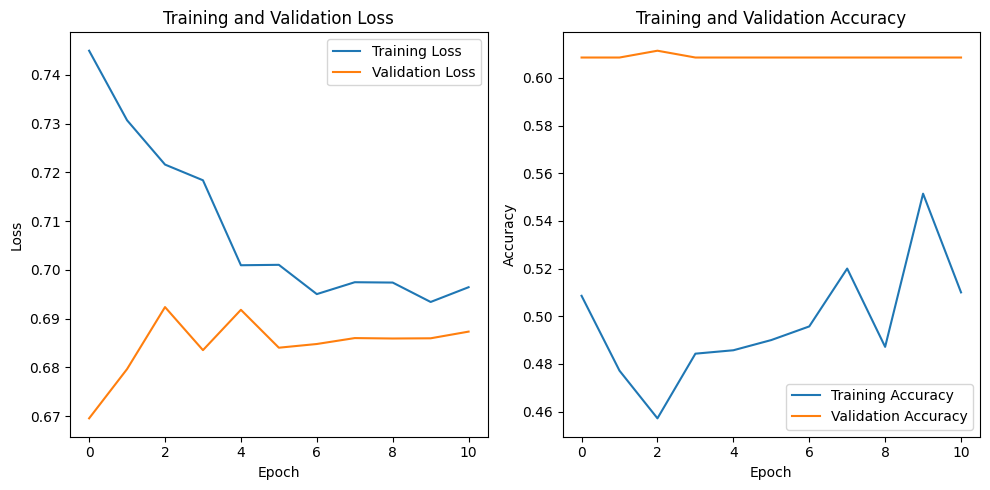

In [ ]:
plot_training_history(history)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 256)               524544    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                      

**Inception** **GoogLeNet**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Creamos el modelo de InceptionV3 preentrenado
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congelamos las capas convolucionales de InceptionV3
for layer in base_model.layers:
    layer.trainable = False

# Añadimos capas adicionales al modelo
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Solo necesitas una neurona para la clasificación binaria
])

# Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Reducimos la tasa de aprendizaje cuando la métrica de validación se estanca
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Configuramos la detención temprana (Early Stopping)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamos el modelo
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, early_stopping]
)

# Evaluamos el modelo en el conjunto de test
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {test_acc}')
print(f'Pérdida en el conjunto de prueba: {test_loss}')


87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/100
22/22 [==============================] - 13s 265ms/step - loss: 1.3652 - accuracy: 0.5214 - val_loss: 0.7024 - val_accuracy: 0.5314 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 1s 65ms/step - loss: 0.9196 - accuracy: 0.5071 - val_loss: 0.6944 - val_accuracy: 0.5457 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 1s 69ms/step - loss: 0.7939 - accuracy: 0.5043 - val_loss: 0.6793 - val_accuracy: 0.5771 - lr: 0.0010
Epoch 4/100
22/22 [==============================] - 1s 69ms/step - loss: 0.7062 - accuracy: 0.5314 - val_loss: 0.6771 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 5/100
22/22 [==============================] - 1s 56ms/step - loss: 0.7009 - accuracy: 0.5686 - val_loss: 0.6911 - val_accuracy: 0.5414 - lr: 0.0010
Epoch 6/100
22/22 [==============================] - 1s 62ms/step - loss: 0.6751 - accuracy: 0.5786 - val_loss: 0.6740 - val_accuracy: 0.5700 - lr: 0.0010
Epo

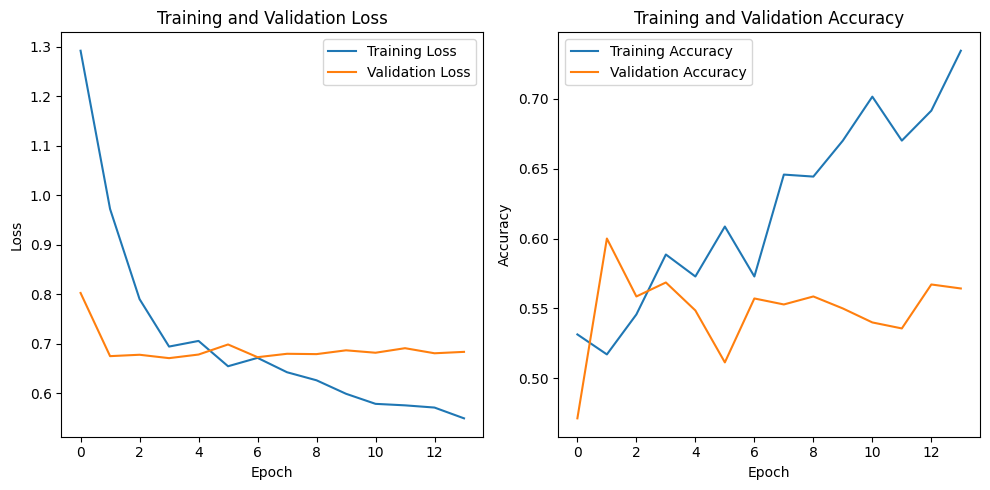

In [ ]:
plot_training_history(history)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                      

**DenseNet121**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Creamos el modelo DenseNet121 preentrenado
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congelamos las capas convolucionales de DenseNet121
for layer in base_model.layers:
    layer.trainable = False

# Añadimos capas adicionales al modelo
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Solo necesitas una neurona para la clasificación binaria
])

# Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Reducimos la tasa de aprendizaje cuando la métrica de validación se estanca
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Configuramos la detención temprana (Early Stopping)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamos el modelo
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, early_stopping]
)

# Evaluamos el modelo en el conjunto de test
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {test_acc}')
print(f'Pérdida en el conjunto de prueba: {test_loss}')


29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/100
22/22 [==============================] - 17s 365ms/step - loss: 1.0673 - accuracy: 0.4986 - val_loss: 0.6948 - val_accuracy: 0.5457 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 2s 80ms/step - loss: 0.7873 - accuracy: 0.5486 - val_loss: 0.6782 - val_accuracy: 0.5814 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 2s 109ms/step - loss: 0.7322 - accuracy: 0.5700 - val_loss: 0.6750 - val_accuracy: 0.5657 - lr: 0.0010
Epoch 4/100
22/22 [==============================] - 2s 113ms/step - loss: 0.7027 - accuracy: 0.5871 - val_loss: 0.6622 - val_accuracy: 0.6214 - lr: 0.0010
Epoch 5/100
22/22 [==============================] - 2s 96ms/step - loss: 0.6569 - accuracy: 0.5957 - val_loss: 0.6764 - val_accuracy: 0.5929 - lr: 0.0010
Epoch 6/100
22/22 [==============================] - 2s 104ms/step - loss: 0.6705 - accuracy: 0.6114 - val_loss: 0.6541 - val_accuracy: 0.6200 - lr: 0.0010


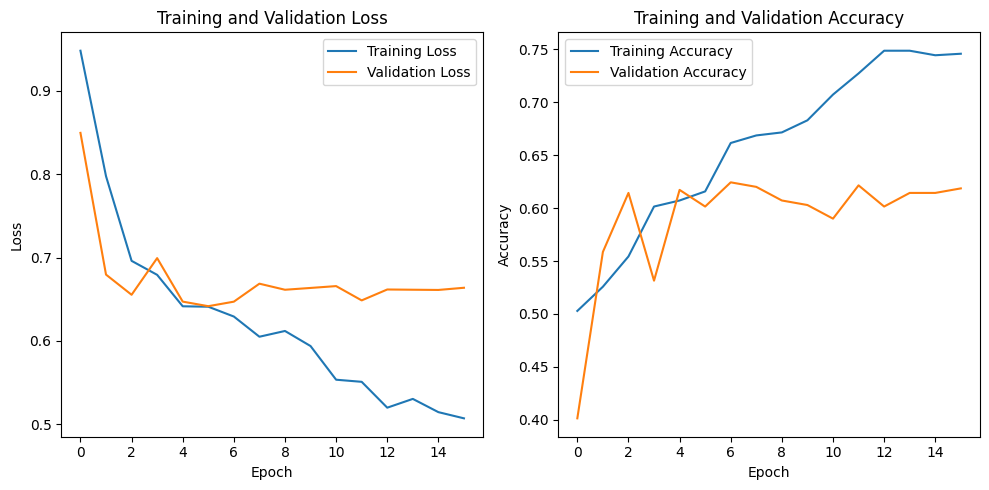

In [ ]:
plot_training_history(history)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d_4  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_11 (Dense)            (None, 256)               262400    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                      

**VGG** (Visual Geometry Group)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Creamos el modelo VGG16 preentrenado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congelamos las capas convolucionales de VGG16
for layer in base_model.layers:
    layer.trainable = False

# Añadimos capas adicionales al modelo
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Solo necesitas una neurona para la clasificación binaria
])

# Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Reducimos la tasa de aprendizaje cuando la métrica de validación se estanca
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Configuramos la detención temprana (Early Stopping)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamos el modelo
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, early_stopping]
)

# Evaluamos el modelo en el conjunto de test
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {test_acc}')
print(f'Pérdida en el conjunto de prueba: {test_loss}')


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/100
22/22 [==============================] - 10s 238ms/step - loss: 0.7438 - accuracy: 0.5000 - val_loss: 0.7012 - val_accuracy: 0.4329 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 2s 103ms/step - loss: 0.7210 - accuracy: 0.5043 - val_loss: 0.6778 - val_accuracy: 0.5900 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 2s 89ms/step - loss: 0.6896 - accuracy: 0.5400 - val_loss: 0.6673 - val_accuracy: 0.5986 - lr: 0.0010
Epoch 4/100
22/22 [==============================] - 2s 87ms/step - loss: 0.6811 - accuracy: 0.5686 - val_loss: 0.6639 - val_accuracy: 0.6100 - lr: 0.0010
Epoch 5/100
22/22 [==============================] - 2s 104ms/step - loss: 0.6715 - accuracy: 0.5814 - val_loss: 0.6537 - val_accuracy: 0.6071 - lr: 0.0010
Epoch 6/100
22/22 [==============================] - 2s 102ms/step - loss: 0.6688 - accuracy: 0.5843 - val_loss: 0.6588 - val_accuracy: 0.6000 - lr: 0.0010


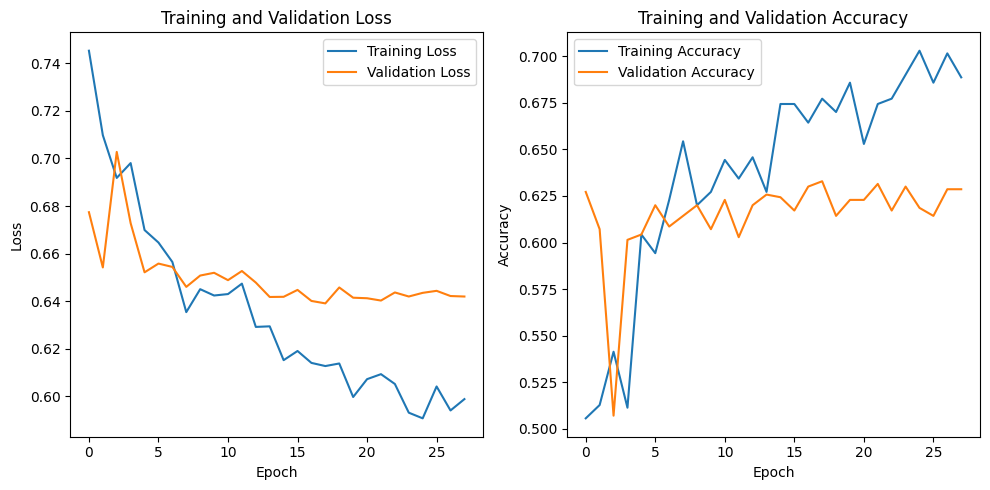

In [ ]:
plot_training_history(history)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_5  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                      

**EfficientNet**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Creamos el modelo EfficientNetB0 preentrenado
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congelamos las capas convolucionales de EfficientNetB0
for layer in base_model.layers:
    layer.trainable = False

# Añadimos capas adicionales al modelo
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Solo necesitas una neurona para la clasificación binaria
])

# Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Reducimos la tasa de aprendizaje cuando la métrica de validación se estanca
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Configuramos la detención temprana (Early Stopping)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamos el modelo
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, early_stopping]
)

# Evaluamos el modelo en el conjunto de test
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {test_acc}')
print(f'Pérdida en el conjunto de prueba: {test_loss}')


16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/100
22/22 [==============================] - 13s 244ms/step - loss: 0.7273 - accuracy: 0.5329 - val_loss: 0.6981 - val_accuracy: 0.3914 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 1s 57ms/step - loss: 0.7455 - accuracy: 0.4943 - val_loss: 0.6774 - val_accuracy: 0.6086 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 1s 53ms/step - loss: 0.7202 - accuracy: 0.4986 - val_loss: 0.6789 - val_accuracy: 0.6086 - lr: 0.0010
Epoch 4/100
22/22 [==============================] - 1s 52ms/step - loss: 0.7023 - accuracy: 0.5543 - val_loss: 0.6938 - val_accuracy: 0.3914 - lr: 0.0010
Epoch 5/100
22/22 [==============================] - 1s 47ms/step - loss: 0.7030 - accuracy: 0.4786 - val_loss: 0.6838 - val_accuracy: 0.6086 - lr: 0.0010
Epoch 6/100
22/22 [==============================] - 1s 47ms/step - loss: 0.6962 - accuracy: 0.5186 - val_loss: 0.6870 - val_accuracy: 0.6086 - lr: 0.0010
Epo

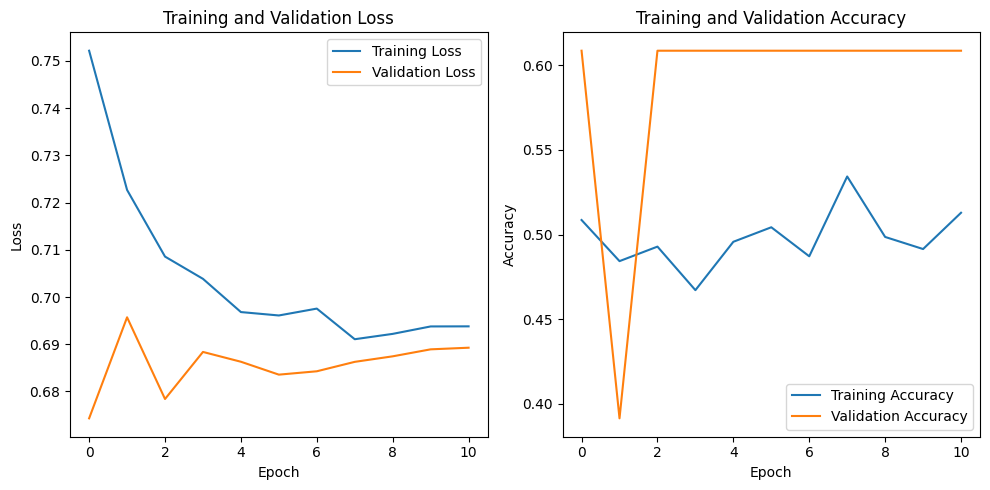

In [ ]:
plot_training_history(history)

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 4, 4, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_6  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_17 (Dense)            (None, 256)               327936    
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dropout_12 (Dropout)        (None, 128)              